### Loading packages

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties

# This will tell matplotlib that we want to include the plots on our notebook, rather than in a new window.
%matplotlib inline

# Here you can control the font for the plots.
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

# Set a random seed
np.random.seed(42)

C:\Users\BOSU ABRAHAM\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
### Models packages to be used

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import   GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

### Loading datasets
We had precipitation and rainfall data from 
-  [World Bank Climate Change Knowledge Portal](https://climateknowledgeportal.worldbank.org/)


In [3]:
### Loading the cleaned datasets
df_data = pd.read_csv("data/clean_data.csv")
# Remove specific columns using the drop method
df_data = df_data.drop('Unnamed: 0', axis=1)
df_data

,year,country,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,...,rural_population_percent_of_total_population_sp_rur_totl_zs,agricultural_machinery_tractors_per_100_sq_km_of_arable_land_ag_lnd_trac_zs,physicians_per_1_000_people_sh_med_phys_zs,nurses_and_midwives_per_1_000_people_sh_med_numw_p3,population_ages_65_and_above_percent_of_total_population_sp_pop_65up_to_zs,population_ages_0_14_percent_of_total_population_sp_pop_0014_to_zs,logistics_performance_index_ability_to_track_and_trace_consignments_1_low_to_5_high_lp_lpi_trac_xq,population_living_in_areas_where_elevation_is_below_5_meters_percent_of_total_population_en_pop_el5m_zs,access_to_electricity_percent_of_population_eg_elc_accs_zs,arable_land_hectares_per_person_ag_lnd_arbl_ha_pc
0,2010,Afghanistan,23.483333,14.175000,12084.4,0.534410,-141355,43.220447,NaN,-1.645391,...,76.263,NaN,0.2365,NaN,2.353431,48.968998,2.37,NaN,42.700000,0.276449
1,2010,Albania,112.025000,12.208333,7820.7,0.459242,-29330,106.314635,45.002579,-0.531617,...,47.837,NaN,1.2347,4.0183,11.614525,20.978534,2.39,NaN,99.644203,0.214897
2,2010,Algeria,7.700000,23.708333,19180.0,0.809914,-33071,15.054684,30.977650,-0.552147,...,32.460,NaN,NaN,NaN,4.830586,27.571393,2.26,NaN,98.910904,0.209224
3,2010,Andorra,72.591667,8.258333,160.0,0.176455,-2864,152.168085,NaN,1.301773,...,11.181,NaN,NaN,NaN,10.825719,16.318626,NaN,NaN,100.000000,0.010766
4,2010,Antigua and Barbuda,240.083333,26.958333,87.8,0.378311,295,194.761364,16.602810,1.301773,...,73.762,NaN,NaN,NaN,7.100181,23.778517,NaN,NaN,98.691376,0.046677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,2020,Uruguay,74.083333,18.008333,20310.0,0.115414,-1486,19.592538,64.933220,1.364934,...,4.485,NaN,NaN,NaN,15.338152,19.796832,NaN,NaN,100.000000,0.590361
1855,2020,Uzbekistan,15.241667,13.566667,36896.6,1.059382,-39203,77.685351,16.281784,-1.072817,...,49.584,NaN,NaN,NaN,4.867530,29.770092,NaN,NaN,100.000000,0.117521
1856,2020,Vanuatu,235.541667,24.266667,4423.0,0.147737,-197,25.568909,NaN,-0.169317,...,74.475,NaN,NaN,NaN,3.713364,39.757287,NaN,NaN,67.299057,0.064167
1857,2020,Zambia,84.800000,22.075000,448140.3,0.324827,9015,25.461353,NaN,-0.733921,...,55.371,NaN,NaN,NaN,1.729860,43.680373,NaN,NaN,44.604069,0.200764


In [4]:
### vulnerability index
vul = pd.read_csv("data/vulnerability/vulnerability.csv")
vul_long = pd.melt(vul, id_vars=['Name', 'ISO3'], var_name='year', value_name='vul_index')
## drop a column
vul_long = vul_long.drop('ISO3', axis=1)
vul_long = vul_long.rename(columns={'Name': 'country'})


vul_long.head(10)

,country,year,vul_index
0,Afghanistan,1995,0.618423
1,Albania,1995,0.433598
2,Algeria,1995,0.400165
3,Andorra,1995,NaN
4,Angola,1995,0.496113
5,Antigua and Barbuda,1995,0.487578
6,Argentina,1995,0.386174
7,Armenia,1995,0.409035
8,Australia,1995,0.315734
9,Austria,1995,0.300395


In [5]:
### Changing the data type of year
vul_long['year'] = vul_long['year'].astype(int)
print(vul_long.dtypes,'\n')


country       object
year           int32
vul_index    float64
dtype: object 



In [6]:
#### Atmospheric temperature
df_atmo = pd.read_csv("data/ts_12month_anomaly_Global_ERA5_2t_202308_1991-2020_v01.1.csv", sep=',', skiprows=8)
df_atmo.head(5)

,Month,Global,European
0,197912,-0.4270,-1.2289
1,198001,-0.4166,-1.2478
2,198002,-0.3825,-1.1866
3,198003,-0.3647,-1.3694
4,198004,-0.3381,-1.3104


In [7]:
# Extract the first four digits of the 'Month' column
df_atmo['year'] = df_atmo['Month'].astype(str).str[:4]
df_atmo = df_atmo.drop(['European','Month'], axis=1)

## rename the Global column
df_atmo = df_atmo.rename(columns={'Global': 'atmos_temp'})

# Now, df contains an additional 'Year' column with the first four digits of 'Month'
print(df_atmo)

     atmos_temp  year
0       -0.4270  1979
1       -0.4166  1980
2       -0.3825  1980
3       -0.3647  1980
4       -0.3381  1980
..          ...   ...
520      0.3171  2023
521      0.3290  2023
522      0.3473  2023
523      0.3768  2023
524      0.4119  2023

[525 rows x 2 columns]


In [8]:
### Using Groupby method to find the annual atmospheric temperature
df_atmo = df_atmo.groupby('year')
df_atmo = df_atmo.mean()
df_atmo = df_atmo.reset_index()
print(df_atmo.dtypes,'\n')
df_atmo.head()

year           object
atmos_temp    float64
dtype: object 



,year,atmos_temp
0,1979,-0.427000
1,1980,-0.310092
2,1981,-0.285208
3,1982,-0.403642
4,1983,-0.320208


In [9]:
### changing the datatype of the year column
df_atmo['year'] = df_atmo['year'].astype(int)
print(df_atmo.dtypes)

year            int32
atmos_temp    float64
dtype: object


In [10]:
### Merge the dataset of cleaned and vulnerability

df_data = pd.merge(df_data,vul_long,on=['country','year'])

### dropping NAS in the vulunerabilty index
df_data = df_data.dropna(subset=['vul_index'])
df_data.describe()

,year,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,...,agricultural_machinery_tractors_per_100_sq_km_of_arable_land_ag_lnd_trac_zs,physicians_per_1_000_people_sh_med_phys_zs,nurses_and_midwives_per_1_000_people_sh_med_numw_p3,population_ages_65_and_above_percent_of_total_population_sp_pop_65up_to_zs,population_ages_0_14_percent_of_total_population_sp_pop_0014_to_zs,logistics_performance_index_ability_to_track_and_trace_consignments_1_low_to_5_high_lp_lpi_trac_xq,population_living_in_areas_where_elevation_is_below_5_meters_percent_of_total_population_en_pop_el5m_zs,access_to_electricity_percent_of_population_eg_elc_accs_zs,arable_land_hectares_per_person_ag_lnd_arbl_ha_pc,vul_index
count,1639.000000,1639.000000,1617.000000,1.639000e+03,1624.000000,1.639000e+03,1639.000000,1156.000000,1639.000000,1620.000000,...,0.0,968.000000,1004.000000,1639.000000,1639.000000,640.000000,149.000000,1639.000000,1628.000000,1639.000000
mean,2015.000000,103.861760,19.858241,1.744711e+05,0.435100,2.466761e+03,213.321691,41.484261,-0.030969,102.236890,...,NaN,2.091409,4.812676,8.213342,28.689881,2.911783,6.811475,80.788196,0.203331,0.436354
std,3.163243,74.197640,8.072004,5.863812e+05,0.350155,1.946001e+05,668.462494,28.503250,0.998753,37.835408,...,NaN,1.656668,4.334499,6.232182,10.955612,0.644478,12.580120,28.446830,0.221771,0.098253
min,2010.000000,1.591667,-7.058333,0.000000e+00,0.047872,-2.290411e+06,1.735397,0.737180,-1.785416,5.389697,...,NaN,0.012600,0.101300,0.175989,11.915707,1.170000,0.000000,4.100000,0.000098,0.244163
25%,2012.000000,45.766667,12.475000,4.423000e+03,0.219590,-1.995950e+04,31.171343,14.739946,-0.780847,75.678443,...,NaN,0.423900,1.366450,3.192555,18.263053,2.447664,0.508642,63.619728,0.072420,0.364042
50%,2015.000000,89.133333,23.408333,2.932000e+04,0.324776,-1.415000e+03,80.169774,40.385435,-0.285695,107.626518,...,NaN,2.101700,3.618900,5.623039,28.045524,2.800000,2.611095,98.500000,0.135670,0.425704
75%,2018.000000,148.358333,26.275000,1.141900e+05,0.535450,1.517000e+04,199.060002,64.592642,0.613019,128.304091,...,NaN,3.293325,6.804400,13.418150,38.871593,3.357582,7.215420,100.000000,0.256600,0.515085
max,2020.000000,391.791667,29.366667,5.115807e+06,2.726739,1.449371e+06,7965.878492,143.310684,2.399264,221.308772,...,NaN,8.419900,22.308000,29.583178,49.897380,4.377678,78.483158,100.000000,1.762411,0.686512


In [11]:
### merging the df_data and atmospheric temperature data
df_data = pd.merge(df_data,df_atmo,on=['year'])
df_data.head()

,year,country,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,...,physicians_per_1_000_people_sh_med_phys_zs,nurses_and_midwives_per_1_000_people_sh_med_numw_p3,population_ages_65_and_above_percent_of_total_population_sp_pop_65up_to_zs,population_ages_0_14_percent_of_total_population_sp_pop_0014_to_zs,logistics_performance_index_ability_to_track_and_trace_consignments_1_low_to_5_high_lp_lpi_trac_xq,population_living_in_areas_where_elevation_is_below_5_meters_percent_of_total_population_en_pop_el5m_zs,access_to_electricity_percent_of_population_eg_elc_accs_zs,arable_land_hectares_per_person_ag_lnd_arbl_ha_pc,vul_index,atmos_temp
0,2010,Afghanistan,23.483333,14.175000,12084.4,0.534410,-141355,43.220447,NaN,-1.645391,...,0.2365,NaN,2.353431,48.968998,2.37,NaN,42.700000,0.276449,0.587810,0.122717
1,2010,Albania,112.025000,12.208333,7820.7,0.459242,-29330,106.314635,45.002579,-0.531617,...,1.2347,4.0183,11.614525,20.978534,2.39,NaN,99.644203,0.214897,0.414749,0.122717
2,2010,Algeria,7.700000,23.708333,19180.0,0.809914,-33071,15.054684,30.977650,-0.552147,...,NaN,NaN,4.830586,27.571393,2.26,NaN,98.910904,0.209224,0.375891,0.122717
3,2010,Antigua and Barbuda,240.083333,26.958333,87.8,0.378311,295,194.761364,16.602810,1.301773,...,NaN,NaN,7.100181,23.778517,NaN,NaN,98.691376,0.046677,0.479311,0.122717
4,2010,Austria,102.458333,6.358333,38632.0,0.193048,22786,101.350024,75.040253,1.596122,...,4.8016,6.7211,17.635641,14.825031,3.83,NaN,100.000000,0.163068,0.295876,0.122717


In [12]:
### check for missing values
miss =df_data.isna().sum()
print(miss)



year                                                                                                          0
country                                                                                                       0
avg_rainfall                                                                                                  0
avg_temp                                                                                                     22
forest_area_sq_km_ag_lnd_frst_k2                                                                              0
co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd                                                        15
net_migration_sm_pop_netm                                                                                     0
population_density_people_per_sq_km_of_land_area_en_pop_dnst                                                  0
school_enrollment_tertiary_percent_gross_se_ter_enrr                                                    

In [13]:
df_data = df_data.fillna(value=df_data.mean())
after_miss =df_data.isna().sum()
print(after_miss)

year                                                                                                          0
country                                                                                                       0
avg_rainfall                                                                                                  0
avg_temp                                                                                                      0
forest_area_sq_km_ag_lnd_frst_k2                                                                              0
co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd                                                         0
net_migration_sm_pop_netm                                                                                     0
population_density_people_per_sq_km_of_land_area_en_pop_dnst                                                  0
school_enrollment_tertiary_percent_gross_se_ter_enrr                                                    

C:\Users\BOSU ABRAHAM\AppData\Local\Temp\ipykernel_21756\1937365166.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_data = df_data.fillna(value=df_data.mean())


In [14]:
# ### We use interpolation to fill in the missing values
# df_data = df_data.interpolate(method='spline', order=5)
# after_miss =df_data.isna().sum()
# print(after_miss)
# #df_data = df_data.dropna(subset=['human_capital_index_hci_scale_0_1_hd_hci_ovrl'])



In [15]:
### droping some of the columns
df_data = df_data.drop(['agricultural_machinery_tractors_per_100_sq_km_of_arable_land_ag_lnd_trac_zs',
                       'population_living_in_areas_where_elevation_is_below_5_meters_percent_of_total_population_en_pop_el5m_zs',
                       'prevalence_of_severe_wasting_weight_for_height_percent_of_children_under_5_sh_svr_wast_zs'], axis=1)

after_miss1 =df_data.isna().sum()
print(after_miss1)

year                                                                                                  0
country                                                                                               0
avg_rainfall                                                                                          0
avg_temp                                                                                              0
forest_area_sq_km_ag_lnd_frst_k2                                                                      0
co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd                                                 0
net_migration_sm_pop_netm                                                                             0
population_density_people_per_sq_km_of_land_area_en_pop_dnst                                          0
school_enrollment_tertiary_percent_gross_se_ter_enrr                                                  0
control_of_corruption_estimate_cc_est                           

### Data Exploration

In [16]:
#### size and shape of yield

print(df_data.size)
print(df_data.shape)

47531
(1639, 29)


In [17]:
df_data.groupby(['year','country'],sort=True)['vul_index'].sum()

year  country            
2010  Afghanistan            0.587810
      Albania                0.414749
      Algeria                0.375891
      Antigua and Barbuda    0.479311
      Austria                0.295876
                               ...   
2020  Uruguay                0.373988
      Uzbekistan             0.362651
      Vanuatu                0.556342
      Zambia                 0.479512
      Zimbabwe               0.508398
Name: vul_index, Length: 1639, dtype: float64

In [18]:
df_data.groupby(['year','country'],sort=True)['vul_index'].sum().nlargest(14)

year  country
2010  Somalia    0.686512
2011  Somalia    0.685899
2012  Somalia    0.685537
2013  Somalia    0.685371
2014  Somalia    0.683824
2015  Somalia    0.683088
2016  Somalia    0.682227
2017  Somalia    0.680729
2018  Somalia    0.679211
2019  Somalia    0.678661
2020  Somalia    0.678095
2016  Chad       0.660172
2017  Chad       0.656674
2019  Chad       0.655291
Name: vul_index, dtype: float64

In [19]:
print(df_data['vul_index'].nunique())
print(df_data['country'].nunique())

1639
149


In [20]:
correlation_data = df_data.select_dtypes(include=[np.number]).corr()
correlation_data

,year,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,...,rural_population_percent_of_total_population_sp_rur_totl_zs,physicians_per_1_000_people_sh_med_phys_zs,nurses_and_midwives_per_1_000_people_sh_med_numw_p3,population_ages_65_and_above_percent_of_total_population_sp_pop_65up_to_zs,population_ages_0_14_percent_of_total_population_sp_pop_0014_to_zs,logistics_performance_index_ability_to_track_and_trace_consignments_1_low_to_5_high_lp_lpi_trac_xq,access_to_electricity_percent_of_population_eg_elc_accs_zs,arable_land_hectares_per_person_ag_lnd_arbl_ha_pc,vul_index,atmos_temp
year,1.000000,-0.013307,0.017312,-0.001127,-0.059292,0.008876,0.013908,0.120870,-0.003816,0.145961,...,-0.044953,0.005444,-0.024172,0.075951,-0.048163,-0.001551,0.086452,-0.025950,-0.030345,0.857000
avg_rainfall,-0.013307,1.000000,0.353481,-0.018593,-0.248654,-0.006785,0.103158,-0.091296,-0.006706,-0.076565,...,0.185276,-0.134575,-0.126646,-0.120941,0.079785,-0.047957,-0.007097,-0.305352,0.233256,-0.000601
avg_temp,0.017312,0.353481,1.000000,-0.162438,-0.119341,-0.160945,0.140308,-0.548562,-0.491247,-0.208132,...,0.300734,-0.493638,-0.569898,-0.686880,0.533028,-0.309501,-0.368702,-0.373666,0.649152,0.017716
forest_area_sq_km_ag_lnd_frst_k2,-0.001127,-0.018593,-0.162438,1.000000,-0.020161,0.257816,-0.065419,0.105043,0.070545,-0.015821,...,-0.139481,-0.014651,0.087869,0.081209,-0.113035,0.141458,0.090271,0.205724,-0.148560,-0.000911
co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,-0.059292,-0.248654,-0.119341,-0.020161,1.000000,-0.082648,-0.076136,-0.003575,-0.272816,0.166091,...,-0.056754,0.003354,-0.088874,-0.129840,-0.108986,-0.096495,0.224506,0.192775,-0.124895,-0.049872
net_migration_sm_pop_netm,0.008876,-0.006785,-0.160945,0.257816,-0.082648,1.000000,-0.013859,0.235718,0.247168,0.133666,...,-0.239360,0.135727,0.217680,0.183645,-0.175590,0.152231,0.084708,0.072999,-0.226556,0.006124
population_density_people_per_sq_km_of_land_area_en_pop_dnst,0.013908,0.103158,0.140308,-0.065419,-0.076136,-0.013859,1.000000,0.058582,0.181826,0.144677,...,-0.157823,-0.021098,0.005238,0.025120,-0.167421,0.117608,0.103081,-0.185743,-0.034764,0.012005
school_enrollment_tertiary_percent_gross_se_ter_enrr,0.120870,-0.091296,-0.548562,0.105043,-0.003575,0.235718,0.058582,1.000000,0.497296,0.375552,...,-0.545092,0.582319,0.484904,0.717816,-0.672989,0.315738,0.517806,0.169861,-0.621121,0.111421
control_of_corruption_estimate_cc_est,-0.003816,-0.006706,-0.491247,0.070545,-0.272816,0.247168,0.181826,0.497296,1.000000,0.453477,...,-0.532378,0.459905,0.633126,0.648925,-0.661678,0.484367,0.472842,-0.044672,-0.630594,-0.003442
mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,0.145961,-0.076565,-0.208132,-0.015821,0.166091,0.133666,0.144677,0.375552,0.453477,1.000000,...,-0.504570,0.307348,0.267901,0.386533,-0.640569,0.312267,0.637759,0.000444,-0.603292,0.109165


<AxesSubplot:>

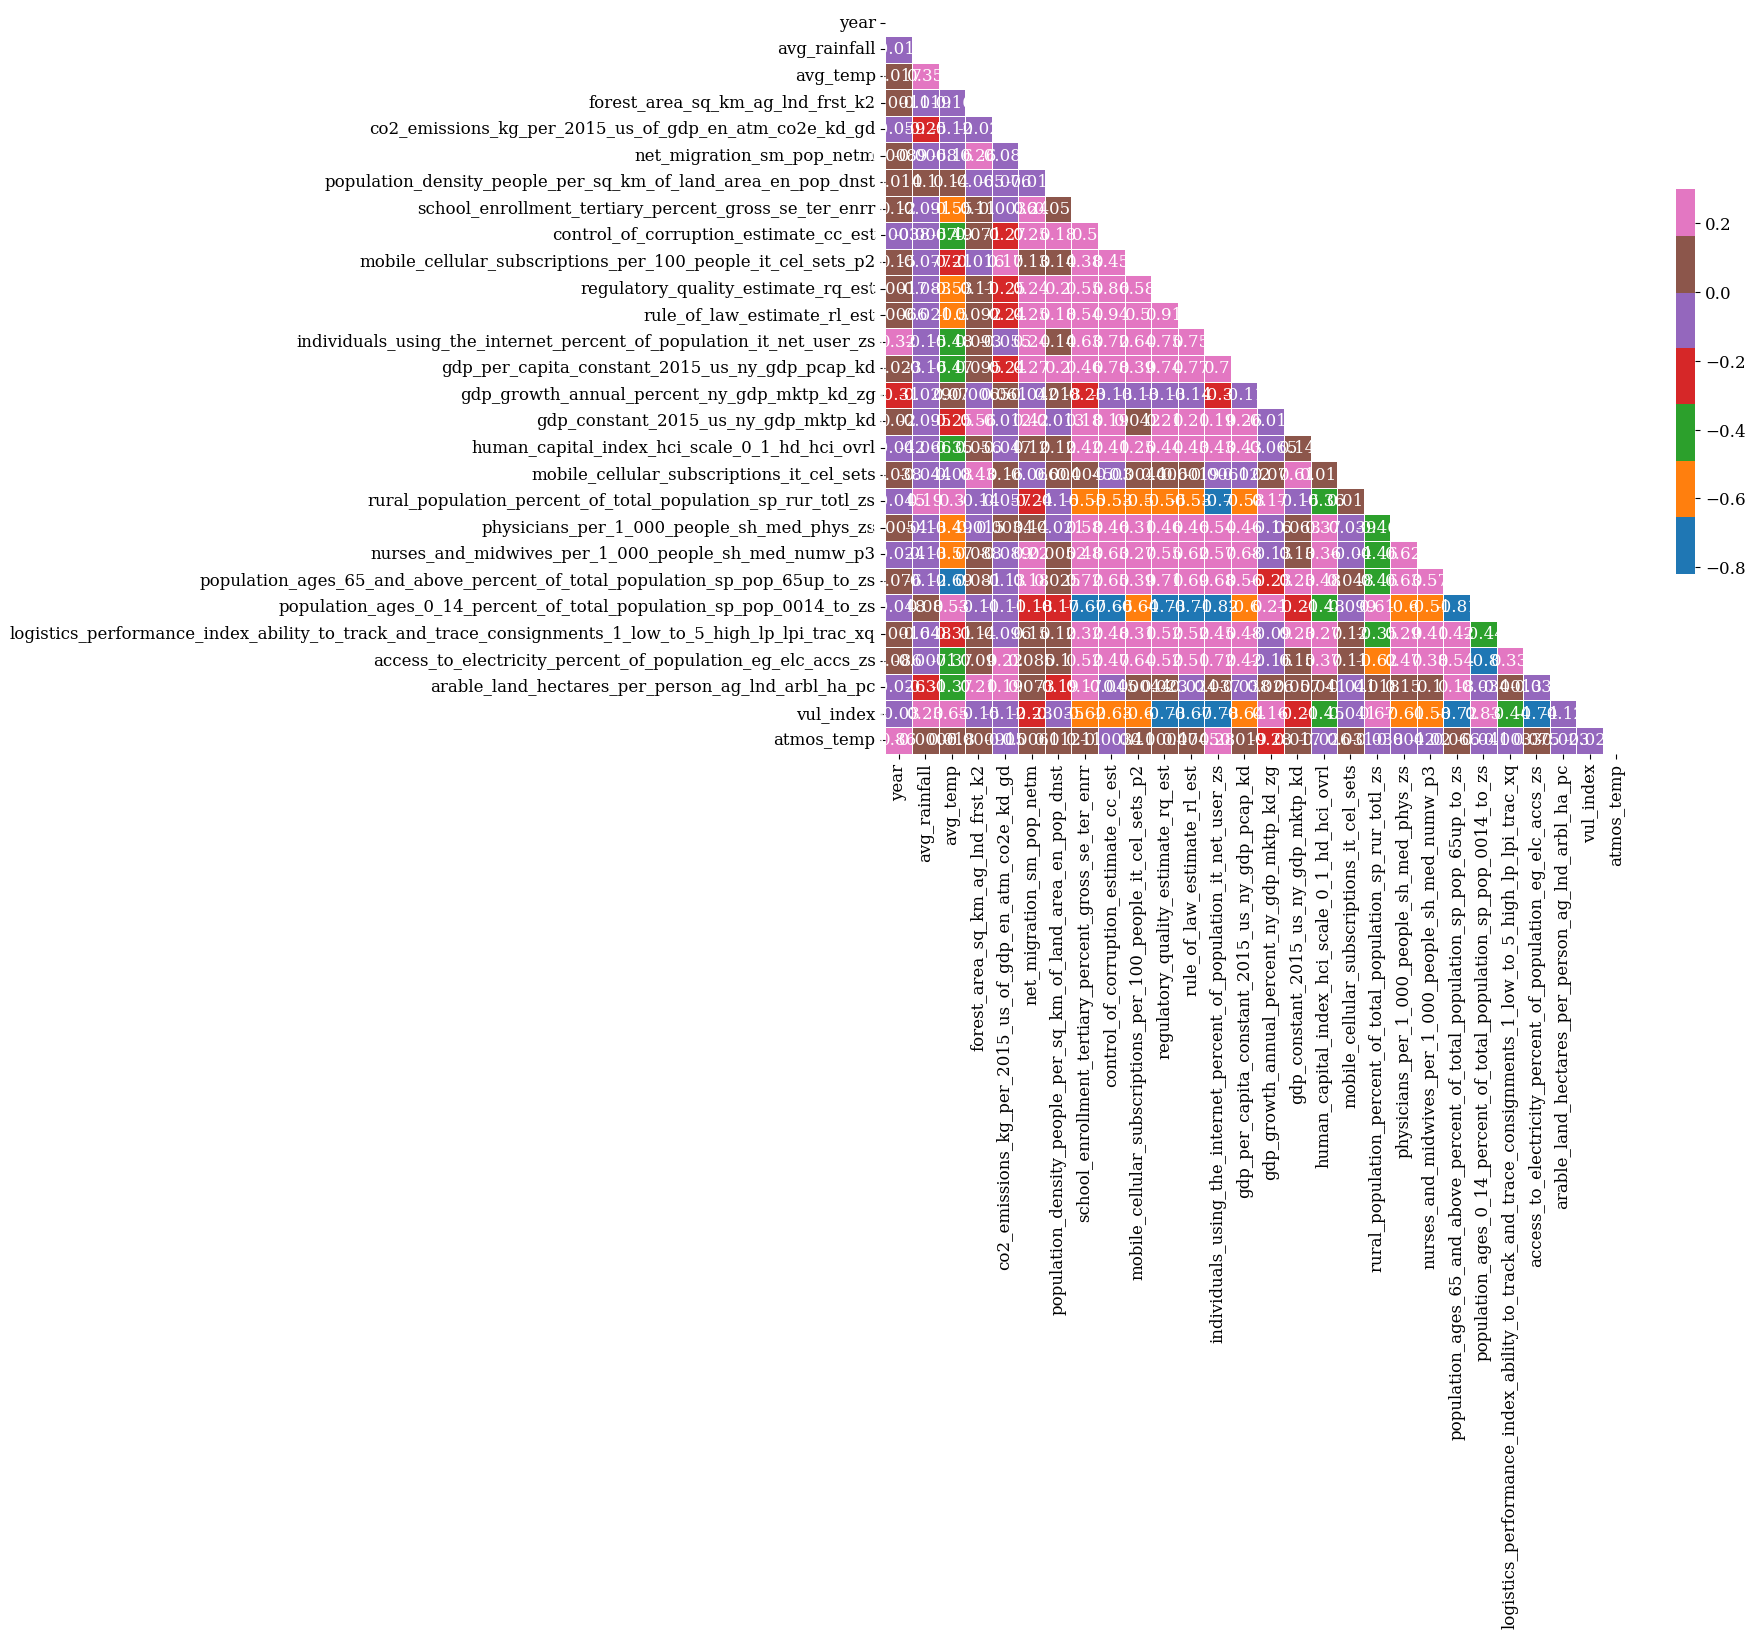

In [21]:
correlation_data = df_data.select_dtypes(include=[np.number]).corr()

mask = np.zeros_like(correlation_data,dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (12,10))

# Generate a custom diverging colormap
#cmap =sns.palettes="vlag"
cmap =sns.color_palette("tab10")
#cmap=plt.cm.Reds

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_data,mask=mask,  annot=True, cmap=cmap, vmax=.3, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink":.5})

#sns.heatmap(correlation_data, mask=mask, cmap=cmap, vmax=.3, center=0,
            #square=True, linewidths=.5, cbar_kws={"shrink": .5});

#plt.savefig('./figures/correlation.eps')


### Feature Engineering

In [22]:
from sklearn.preprocessing import OneHotEncoder


In [23]:

# Convert 'year' to categorical variable
df_data['year'] = df_data['year'].astype('category')


In [24]:
##Encoding categorical variables
df_data_dummy = pd.get_dummies(df_data,columns=['country','year'],
                               prefix=['country','year'])
df_data_dummy.head()






,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,regulatory_quality_estimate_rq_est,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
0,23.483333,14.175000,12084.4,0.534410,-141355,43.220447,41.484261,-1.645391,36.239655,-1.516528,...,0,0,0,0,0,0,0,0,0,0
1,112.025000,12.208333,7820.7,0.459242,-29330,106.314635,45.002579,-0.531617,92.413400,0.233282,...,0,0,0,0,0,0,0,0,0,0
2,7.700000,23.708333,19180.0,0.809914,-33071,15.054684,30.977650,-0.552147,91.420824,-1.104801,...,0,0,0,0,0,0,0,0,0,0
3,240.083333,26.958333,87.8,0.378311,295,194.761364,16.602810,1.301773,196.009102,0.642826,...,0,0,0,0,0,0,0,0,0,0
4,102.458333,6.358333,38632.0,0.193048,22786,101.350024,75.040253,1.596122,146.373912,1.450516,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# shape and size of the dumming variables
print(df_data_dummy.shape)
print(df_data_dummy.size)

(1639, 187)
306493


In [26]:
miss =df_data_dummy.isna().sum()
print(miss)

avg_rainfall                                             0
avg_temp                                                 0
forest_area_sq_km_ag_lnd_frst_k2                         0
co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd    0
net_migration_sm_pop_netm                                0
                                                        ..
year_2016                                                0
year_2017                                                0
year_2018                                                0
year_2019                                                0
year_2020                                                0
Length: 187, dtype: int64


In [27]:
### selecting the features
features = df_data_dummy.loc[:,df_data_dummy.columns != 'vul_index']
#features = features.drop('year', axis=1)
features.shape

(1639, 186)

In [28]:
# # Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(12)

### A function to check our targeted variable to see if it is normally distributed

In [29]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

def check_normality(df, cname, return_log_transform=True):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, 
                                        figsize=(12,12),
                                        dpi = 80)
    
    
    # <<< 1ST Plot >>> 
    sns.distplot(df[cname] , 
                  fit=norm,
                  hist_kws=dict(edgecolor="black", 
                                    linewidth=2,
                                   color='blue'), 
                  kde_kws={'linestyle':'--', 
                           'linewidth':2,
                          "color": "darkgreen", 
                           "label": "KDE"},
                        ax=ax1)
    ax1.grid(True, linestyle='--')

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[cname])
    # print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    ax1.legend(['Normal dist. ($\mu=$ {:.2f}; $\sigma=$ {:.2f})'.format(mu, sigma)],
                loc='best')
    # ax1.set_ylabel('Frequency')
    ax1.set_title('{} distribution'.format(cname))
   

    # <<< 2ND Plot >>> 
    #Get QQ-plot
    res = stats.probplot(np.unique(df[cname].values),
                         plot=ax2, 
                         rvalue=True)
    ax2.grid(True, linestyle='--')
    
    #print('yes')

    ## Log-transformation of the target variable
    #We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
#     df[cname] = np.log1p(df[cname])

    #Check the new distribution 
    sns.distplot(np.log1p(df[cname]),
                 fit=norm,
                 hist_kws=dict(edgecolor="black", 
                                    linewidth=2,
                                   color='blue'), 
                  kde_kws={'linestyle':'--', 
                           'linewidth':2,
                          "color": "darkgreen", 
                           "label": "KDE"},
                        ax=ax3)
    ax3.grid(True, linestyle='--')

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(np.log1p(df[cname]))
    # print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    # plt.ylabel('Frequency')
    ax3.set_title('{} distribution in log scale'.format(cname))

    #Get also the QQ-plot
    res = stats.probplot(np.unique(np.log1p(df[cname]).values), plot=ax4,
                    rvalue=True)
    
    fig.tight_layout()
    #fig.savefig('./Fig2/dist.eps')
    #fig.savefig('./Fig2/dist.jpeg')
    
    if return_log_transform is True:
        return np.log1p(df[cname])

C:\Users\BOSU ABRAHAM\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\BOSU ABRAHAM\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


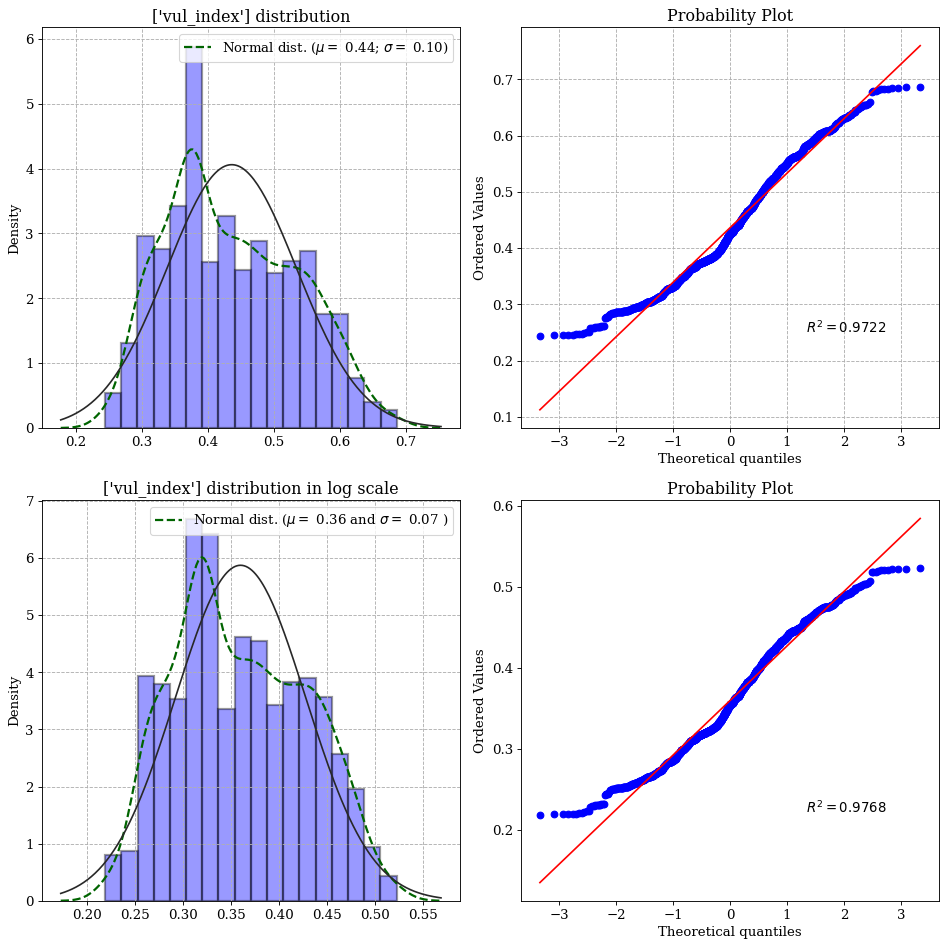

In [30]:
### Checking for the normality of the targeted variable
df_data['vul_index_log']=check_normality(df=df_data, cname=["vul_index"], return_log_transform=True)



### Scaling Features

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
### Normalizing the features
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

features.shape

(1639, 186)

###  Data Splitting into training and testing

In [33]:
### The target variable
label = df_data['vul_index']

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
train_X, test_X, train_Y, test_Y= train_test_split(features, label,test_size=0.3,
                                                   random_state=42)
print('shape of train data:', train_X.shape)
print('shape of test data:', test_X.shape)
print('shape of train label:', train_Y.shape)
print('shape of test label:', test_Y.shape)

shape of train data: (1147, 186)
shape of test data: (492, 186)
shape of train label: (1147,)
shape of test label: (492,)


## Model Comparison & Selection

In [36]:

from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score

In [37]:
### r2 is r2_score
def compare_models(model):
    model_name = model.__class__.__name__
    fit = model.fit(train_X,train_Y)
    y_pred = fit.predict(test_X)
    r2 = r2_score(test_Y,y_pred)
    return([model_name, r2])

### rmse is the root mean square error
def compare_models1(model):
    model_name = model.__class__.__name__
    fit = model.fit(train_X,train_Y)
    y_pred = fit.predict(test_X)
    mse = mean_squared_error(test_Y, y_pred)
    return([model_name, mse])



###### mae represent mean absolute error
def compare_models2(model):
    model_name = model.__class__.__name__
    fit = model.fit(train_X,train_Y)
    y_pred = fit.predict(test_X)
    mae = mean_absolute_error(test_Y,y_pred)
    return([model_name, mae])


#3## MAPE
def compare_models3(model):
    model_name = model.__class__.__name__
    fit = model.fit(train_X,train_Y)
    y_pred = fit.predict(test_X)
    mape = mean_absolute_percentage_error(test_Y,y_pred)
    return([model_name, mape])

In [38]:
models = [
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    SVR(),
    LGBMRegressor(),
    XGBRegressor()
]

In [39]:
model_train  = list(map(compare_models,models))
model_train1 = list(map(compare_models1, models))
model_train2 = list(map(compare_models2, models))
model_train3 = list(map(compare_models3, models))
print("Model_train check R2_Score:",*model_train, sep="\n")
print()
print("Model_train1 check RMSE:", *model_train1, sep="\n")
print()
print("Model_train2 check MAE:", *model_train2,sep="\n")
print("Model_train3 check MAPE:", *model_train3,sep="\n")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6385
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 37
[LightGBM] [Info] Start training from score 0.434493
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6385
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 37
[LightGBM] [Info] Start training from score 0.434493
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6385
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 37
[LightGBM] [Info] Start traini

In [40]:
## we check the time it takes each model to run
import time

In [41]:
import time
### Random Forest 
rf = RandomForestRegressor()

start_time = time.time()

#rf_reg_tuned.fit(test_X, train_Y)
model_rf = rf.fit(train_X,train_Y)

print("RF--- %s seconds ---" % (time.time() - start_time))

### Gradient Boosting
gbm = GradientBoostingRegressor()
start_time = time.time()

#gbm_reg_tuned.fit(test_X, train_Y)
model_gbm = gbm.fit(train_X,train_Y)

print("GBM--- %s seconds ---" % (time.time() - start_time))

### Light Gradient Bossting
lgbm = LGBMRegressor()
start_time = time.time()

#lgbm_reg_tuned.fit(test_X, train_Y)
model_lgbm = lgbm.fit(train_X,train_Y)

print("LGBM--- %s seconds ---" % (time.time() - start_time))

### Extreme Gradient Boosting
xgbm = XGBRegressor()
#xgbm_reg_tuned.fit(test_X, train_Y)
model_xgbm = xgbm.fit(train_X,train_Y)

print("XGBM--- %s seconds ---" % (time.time() - start_time))



###################
svm1= SVR()
start_time = time.time()

#rf_reg_tuned.fit(test_X, train_Y)
model_svm = svm1.fit(train_X,train_Y)

print("SVM--- %s seconds ---" % (time.time() - start_time))




RF--- 3.156052827835083 seconds ---
GBM--- 1.6888477802276611 seconds ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6385
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 37
[LightGBM] [Info] Start training from score 0.434493
LGBM--- 0.30788755416870117 seconds ---
XGBM--- 0.9217321872711182 seconds ---
SVM--- 0.04143023490905762 seconds ---


## Line Curve

In [42]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [43]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

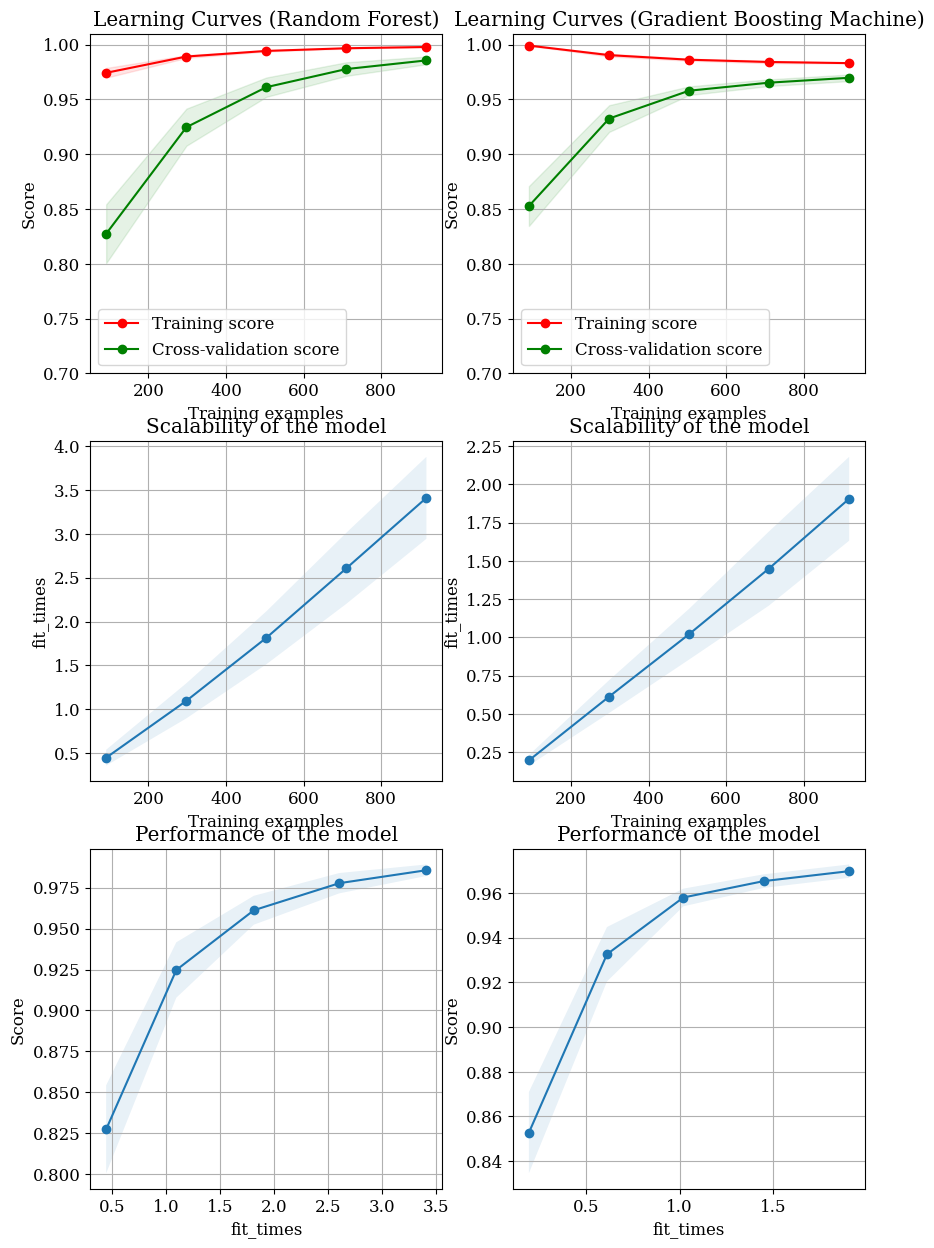

In [44]:
### Learning curves of RF and GBM

fig, axes = plt.subplots(3, 2, figsize=(10, 15))



title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestRegressor()
plot_learning_curve(
    estimator, title, train_X, train_Y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (Gradient Boosting Machine)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000,
                                      #random_state=1, subsample=0.75)
estimator =GradientBoostingRegressor()
plot_learning_curve(
    estimator, title, train_X, train_Y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

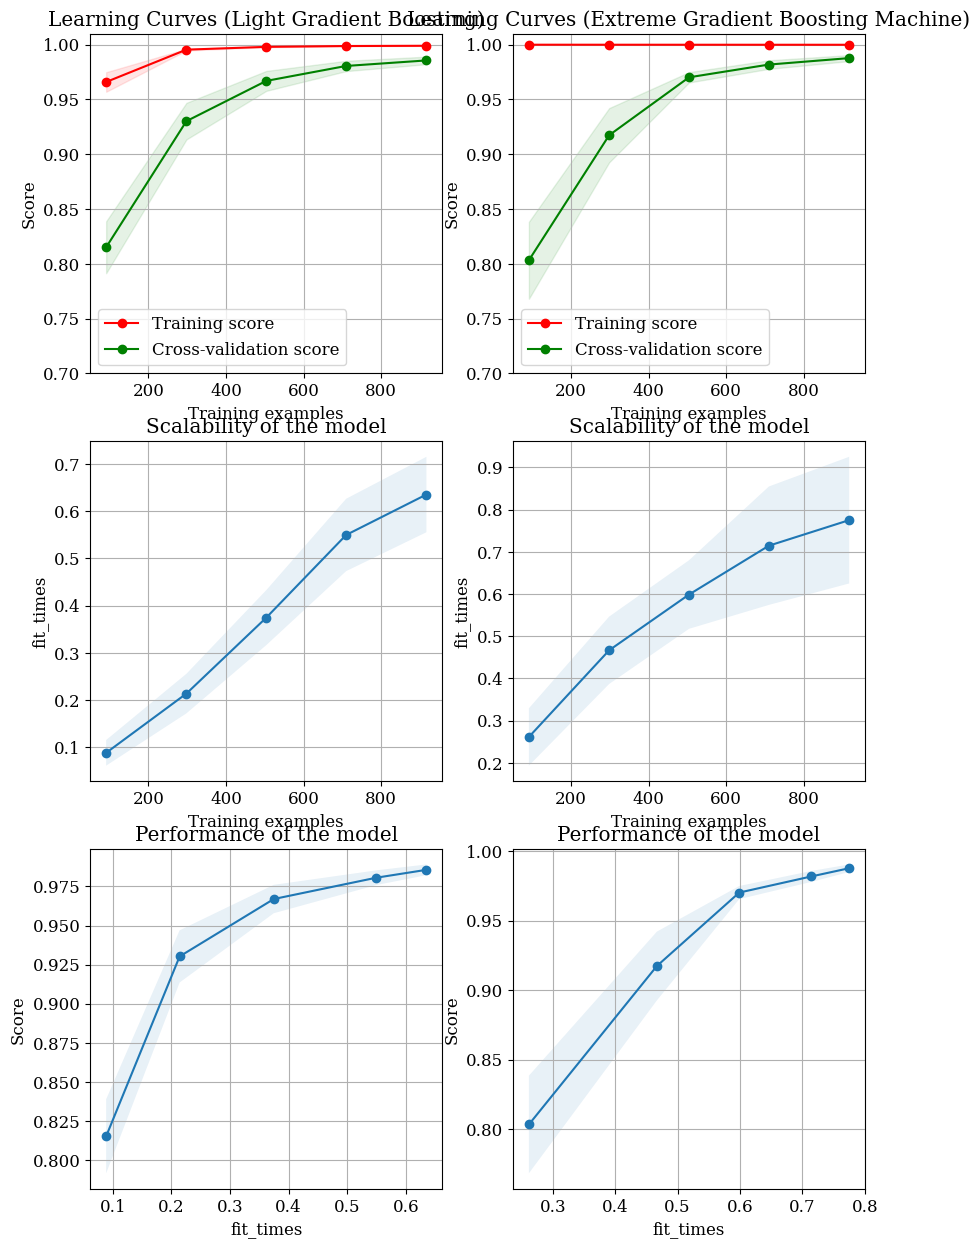

In [45]:
### Learning curves of LGBM and XGBM

fig, axes = plt.subplots(3, 2, figsize=(10, 15))



title = "Learning Curves (Light Gradient Boosting)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LGBMRegressor()
plot_learning_curve(
    estimator, title, train_X, train_Y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (Extreme Gradient Boosting Machine)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000,
                                      #random_state=1, subsample=0.75)
estimator =XGBRegressor()
plot_learning_curve(
    estimator, title, train_X, train_Y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

In [39]:
# df_data_dummy = df_data_dummy.drop(['year'], axis=1)
# df_data_dummy.head()

In [47]:
#####

test_df = pd.DataFrame(test_X,
                       columns=df_data_dummy.loc[:,df_data_dummy.columns !='vul_index'].columns)

In [48]:
#setting test data to columns from dataframe and excluding 'atmos_temp' values where ML model should be predicting 

test_df=pd.DataFrame(test_X,columns=df_data_dummy.loc[:, df_data_dummy.columns != 'vul_index'].columns) 

# using stack function to return a reshaped DataFrame by pivoting the columns of the current dataframe

cntry=test_df[[col for col in test_df.columns if 'country' in col]].stack()[test_df[[col for col in test_df.columns if 'country' in col]].stack()>0]
cntrylist=list(pd.DataFrame(cntry).index.get_level_values(1))
countries=[i.split("_")[1] for i in cntrylist]

yr=test_df[[col for col in test_df.columns if 'year' in col]].stack()[test_df[[col for col in test_df.columns if 'year' in col]].stack()>0]
yrlist=list(pd.DataFrame(yr).index.get_level_values(1))
year=[i.split("_")[1] for i in yrlist]

In [49]:
test_df

,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,regulatory_quality_estimate_rq_est,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
0,0.204,0.810,0.005,0.026,0.610,0.022,0.001,0.245,0.133,0.330,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.274,0.276,0.024,0.015,0.615,0.002,0.606,0.920,0.477,0.878,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2,0.052,0.211,0.028,0.557,0.614,0.000,0.440,0.305,0.490,0.487,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
3,0.473,0.897,0.003,0.067,0.613,0.002,0.162,0.389,0.202,0.408,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.164,0.609,0.008,0.092,0.607,0.010,0.994,0.430,0.495,0.622,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,0.184,0.739,0.013,0.068,0.601,0.007,0.018,0.341,0.139,0.463,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
488,0.095,0.692,0.034,0.466,0.631,0.005,0.116,0.383,0.571,0.596,...,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
489,0.165,0.467,0.022,0.060,0.728,0.029,0.475,0.856,0.590,0.896,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
490,0.439,0.919,0.000,0.333,0.612,0.035,0.286,0.394,0.571,0.622,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [50]:

test_df.drop([col for col in test_df.columns if 'year' in col],axis=1,inplace=True)
test_df.drop([col for col in test_df.columns if 'country' in col],axis=1,inplace=True)
test_df.head()

,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,regulatory_quality_estimate_rq_est,...,mobile_cellular_subscriptions_it_cel_sets,rural_population_percent_of_total_population_sp_rur_totl_zs,physicians_per_1_000_people_sh_med_phys_zs,nurses_and_midwives_per_1_000_people_sh_med_numw_p3,population_ages_65_and_above_percent_of_total_population_sp_pop_65up_to_zs,population_ages_0_14_percent_of_total_population_sp_pop_0014_to_zs,logistics_performance_index_ability_to_track_and_trace_consignments_1_low_to_5_high_lp_lpi_trac_xq,access_to_electricity_percent_of_population_eg_elc_accs_zs,arable_land_hectares_per_person_ag_lnd_arbl_ha_pc,atmos_temp
0,0.204,0.810,0.005,0.026,0.610,0.022,0.001,0.245,0.133,0.330,...,0.003,0.939,0.247,0.212,0.109,0.904,0.455,0.081,0.124,0.192
1,0.274,0.276,0.024,0.015,0.615,0.002,0.606,0.920,0.477,0.878,...,0.003,0.191,0.599,0.825,0.597,0.139,0.543,1.000,0.085,1.000
2,0.052,0.211,0.028,0.557,0.614,0.000,0.440,0.305,0.490,0.487,...,0.002,0.355,0.339,0.179,0.126,0.472,0.405,0.904,0.248,0.913
3,0.473,0.897,0.003,0.067,0.613,0.002,0.162,0.389,0.202,0.408,...,0.000,0.612,0.247,0.087,0.137,0.541,0.543,0.911,0.126,0.192
4,0.164,0.609,0.008,0.092,0.607,0.010,0.994,0.430,0.495,0.622,...,0.007,0.231,0.749,0.164,0.738,0.062,0.543,1.000,0.113,0.734


In [51]:
test_df['country']=countries
test_df['year']=year
test_df.head()

,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,regulatory_quality_estimate_rq_est,...,physicians_per_1_000_people_sh_med_phys_zs,nurses_and_midwives_per_1_000_people_sh_med_numw_p3,population_ages_65_and_above_percent_of_total_population_sp_pop_65up_to_zs,population_ages_0_14_percent_of_total_population_sp_pop_0014_to_zs,logistics_performance_index_ability_to_track_and_trace_consignments_1_low_to_5_high_lp_lpi_trac_xq,access_to_electricity_percent_of_population_eg_elc_accs_zs,arable_land_hectares_per_person_ag_lnd_arbl_ha_pc,atmos_temp,country,year
0,0.204,0.810,0.005,0.026,0.610,0.022,0.001,0.245,0.133,0.330,...,0.247,0.212,0.109,0.904,0.455,0.081,0.124,0.192,Malawi,2014
1,0.274,0.276,0.024,0.015,0.615,0.002,0.606,0.920,0.477,0.878,...,0.599,0.825,0.597,0.139,0.543,1.000,0.085,1.000,Norway,2020
2,0.052,0.211,0.028,0.557,0.614,0.000,0.440,0.305,0.490,0.487,...,0.339,0.179,0.126,0.472,0.405,0.904,0.248,0.913,Mongolia,2016
3,0.473,0.897,0.003,0.067,0.613,0.002,0.162,0.389,0.202,0.408,...,0.247,0.087,0.137,0.541,0.543,0.911,0.126,0.192,Belize,2014
4,0.164,0.609,0.008,0.092,0.607,0.010,0.994,0.430,0.495,0.622,...,0.749,0.164,0.738,0.062,0.543,1.000,0.113,0.734,Greece,2019


In [52]:
lgm = LGBMRegressor()
model = lgm.fit(train_X,train_Y)

test_df["vulnerability_predicted"]= model.predict(test_X)
test_df["vulnerability_actual"]=pd.DataFrame(test_Y)["vul_index"].tolist()

test_df.head()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6385
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 37
[LightGBM] [Info] Start training from score 0.434493


,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,regulatory_quality_estimate_rq_est,...,population_ages_65_and_above_percent_of_total_population_sp_pop_65up_to_zs,population_ages_0_14_percent_of_total_population_sp_pop_0014_to_zs,logistics_performance_index_ability_to_track_and_trace_consignments_1_low_to_5_high_lp_lpi_trac_xq,access_to_electricity_percent_of_population_eg_elc_accs_zs,arable_land_hectares_per_person_ag_lnd_arbl_ha_pc,atmos_temp,country,year,vulnerability_predicted,vulnerability_actual
0,0.204,0.810,0.005,0.026,0.610,0.022,0.001,0.245,0.133,0.330,...,0.109,0.904,0.455,0.081,0.124,0.192,Malawi,2014,0.547,0.545
1,0.274,0.276,0.024,0.015,0.615,0.002,0.606,0.920,0.477,0.878,...,0.597,0.139,0.543,1.000,0.085,1.000,Norway,2020,0.260,0.262
2,0.052,0.211,0.028,0.557,0.614,0.000,0.440,0.305,0.490,0.487,...,0.126,0.472,0.405,0.904,0.248,0.913,Mongolia,2016,0.373,0.380
3,0.473,0.897,0.003,0.067,0.613,0.002,0.162,0.389,0.202,0.408,...,0.137,0.541,0.543,0.911,0.126,0.192,Belize,2014,0.451,0.466
4,0.164,0.609,0.008,0.092,0.607,0.010,0.994,0.430,0.495,0.622,...,0.738,0.062,0.543,1.000,0.113,0.734,Greece,2019,0.331,0.328


In [ ]:


# Load your trained model
lgm = LGBMRegressor()
model = lgm.fit(train_X, train_Y)

# Define the number of future years for prediction
num_future_years = 10

# Use 2020 as the last year in your training data
last_year_in_data = 2020

# Create a DataFrame for future years
future_years = range(last_year_in_data + 1, last_year_in_data + 1 + num_future_years)
future_data = pd.DataFrame({'Year': future_years})


